In [4]:
import pandas as pd


column_names = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", 
    "is_guest_login", "count", "srv_count", "serror_rate", "srv_serror_rate",
    "rerror_rate", "srv_rerror_rate", "same_srv_rate", "diff_srv_rate", 
    "srv_diff_host_rate", "dst_host_count", "dst_host_srv_count",
    "dst_host_same_srv_rate", "dst_host_diff_srv_rate", "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate", "dst_host_serror_rate", "dst_host_srv_serror_rate",
    "dst_host_rerror_rate", "dst_host_srv_rerror_rate", "label"
]

# Load the dataset
train_file = "nsl-kdd/KDDTrain+.txt" 
test_file = "nsl-kdd/KDDTest+.txt"    

df_train = pd.read_csv(train_file, names=column_names, delimiter=",", header=None)
df_test = pd.read_csv(test_file, names=column_names, delimiter=",", header=None)

print("Training Data Shape:", df_train.shape)
print("Testing Data Shape:", df_test.shape)
print(df_train.head()) 


Training Data Shape: (125973, 42)
Testing Data Shape: (22544, 42)
  duration protocol_type service  flag  src_bytes  dst_bytes  land  \
0      tcp      ftp_data      SF   491          0          0     0   
0      udp         other      SF   146          0          0     0   
0      tcp       private      S0     0          0          0     0   
0      tcp          http      SF   232       8153          0     0   
0      tcp          http      SF   199        420          0     0   

   wrong_fragment  urgent  hot  ...  dst_host_srv_count  \
0               0       0    0  ...                0.17   
0               0       0    0  ...                0.00   
0               0       0    0  ...                0.10   
0               0       0    0  ...                1.00   
0               0       0    0  ...                1.00   

   dst_host_same_srv_rate  dst_host_diff_srv_rate  \
0                    0.03                    0.17   
0                    0.60                    0.88   

In [5]:
from sklearn.preprocessing import LabelEncoder

categorical_columns = ["protocol_type", "service", "flag", "label"]

# Apply Label Encoding for Training Data
label_encoders = {}
for col in categorical_columns:
    label_encoders[col] = LabelEncoder()
    df_train[col] = label_encoders[col].fit_transform(df_train[col])

# Safe transformation for Testing Data 
for col in categorical_columns:
    df_test[col] = df_test[col].apply(lambda x: label_encoders[col].transform([x])[0] if x in label_encoders[col].classes_ else -1)


In [6]:
from sklearn.model_selection import train_test_split

# Define X (features) and y (labels)
X_train = df_train.drop("label", axis=1)  
y_train = df_train["label"]

X_test = df_test.drop("label", axis=1)
y_test = df_test["label"]

print("Training Set Shape:", X_train.shape)
print("Testing Set Shape:", X_test.shape)


X_train["dst_host_srv_rerror_rate"] = pd.to_numeric(X_train["dst_host_srv_rerror_rate"], errors="coerce")
X_test["dst_host_srv_rerror_rate"] = pd.to_numeric(X_test["dst_host_srv_rerror_rate"], errors="coerce")


X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


print(X_train.dtypes)  



Training Set Shape: (125973, 41)
Testing Set Shape: (22544, 41)
duration                        object
protocol_type                    int64
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                      float64


In [7]:
# Convert ALL columns to numeric 
X_train = X_train.apply(pd.to_numeric, errors="coerce")
X_test = X_test.apply(pd.to_numeric, errors="coerce")


X_train = X_train.fillna(0)
X_test = X_test.fillna(0)


print(X_train.dtypes)


duration                       float64
protocol_type                    int64
service                          int64
flag                             int64
src_bytes                        int64
dst_bytes                        int64
land                             int64
wrong_fragment                   int64
urgent                           int64
hot                              int64
num_failed_logins                int64
logged_in                        int64
num_compromised                  int64
root_shell                       int64
su_attempted                     int64
num_root                         int64
num_file_creations               int64
num_shells                       int64
num_access_files                 int64
num_outbound_cmds                int64
is_host_login                    int64
is_guest_login                   int64
count                            int64
srv_count                      float64
serror_rate                    float64
srv_serror_rate          

In [14]:
import torch


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using Device: {device}")

X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.long).to(device)

X_test_tensor = torch.tensor(X_test.values, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.long).to(device)

print(" Data is now ready for training!")


Using Device: cpu
 Data is now ready for training!


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
from sklearn.preprocessing import StandardScaler


class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, output_dim)
    
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)




scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


noise_factor = 0.01
X_train_augmented = X_train_scaled + noise_factor * np.random.randn(*X_train_scaled.shape)




input_dim = X_train.shape[1]  
output_dim = len(np.unique(y_train))  
learning_rate = 0.00002  
epochs = 80  
batch_size = 128 


model = DQN(input_dim, output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.5)
criterion = nn.CrossEntropyLoss()

for epoch in range(epochs):
    model.train()
    total_loss = 0
    
    for i in range(0, len(X_train_tensor), batch_size):
        batch_X = X_train_tensor[i:i+batch_size]
        batch_y = y_train_tensor[i:i+batch_size]
        
        optimizer.zero_grad()
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        total_loss += loss.item()
    
    scheduler.step() 

    print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss:.4f}")


torch.save(model.state_dict(), "dqn_ids_model_final_v2.pth")
print(" Final Model saved as dqn_ids_model_final_v2.pth")

model.eval()
with torch.no_grad():
    test_outputs = model(X_test_tensor)
    predictions = torch.argmax(test_outputs, axis=1)
    accuracy = (predictions == y_test_tensor).float().mean().item()
    
print(f" Final Model Accuracy on Test Set: {accuracy * 100:.2f}%")


Epoch [1/150], Loss: 4586.2618, Train Acc: 71.16%, Test Acc: 59.93%
Epoch [2/150], Loss: 4023.7923, Train Acc: 73.81%, Test Acc: 60.46%
Epoch [3/150], Loss: 3818.1541, Train Acc: 74.76%, Test Acc: 59.66%
Epoch [4/150], Loss: 3698.8039, Train Acc: 75.44%, Test Acc: 61.11%
Epoch [5/150], Loss: 3602.2633, Train Acc: 76.02%, Test Acc: 60.58%
Epoch [6/150], Loss: 3525.2322, Train Acc: 76.49%, Test Acc: 61.16%
Epoch [7/150], Loss: 3467.0860, Train Acc: 76.89%, Test Acc: 61.56%
Epoch [8/150], Loss: 3417.3007, Train Acc: 77.22%, Test Acc: 61.40%
Epoch [9/150], Loss: 3380.3273, Train Acc: 77.44%, Test Acc: 62.06%
Epoch [10/150], Loss: 3340.9144, Train Acc: 77.73%, Test Acc: 61.25%
Epoch [11/150], Loss: 3313.8844, Train Acc: 77.87%, Test Acc: 61.23%
Epoch [12/150], Loss: 3285.8366, Train Acc: 78.10%, Test Acc: 60.69%
Epoch [13/150], Loss: 3258.0619, Train Acc: 78.28%, Test Acc: 61.65%
Epoch [14/150], Loss: 3113.1576, Train Acc: 79.13%, Test Acc: 61.34%
Epoch [15/150], Loss: 3080.0355, Train Acc:

KeyboardInterrupt: 

In [26]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np


class_weights = compute_class_weight(class_weight="balanced", classes=np.unique(y_train), y=y_train)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)


criterion = nn.CrossEntropyLoss(weight=class_weights)


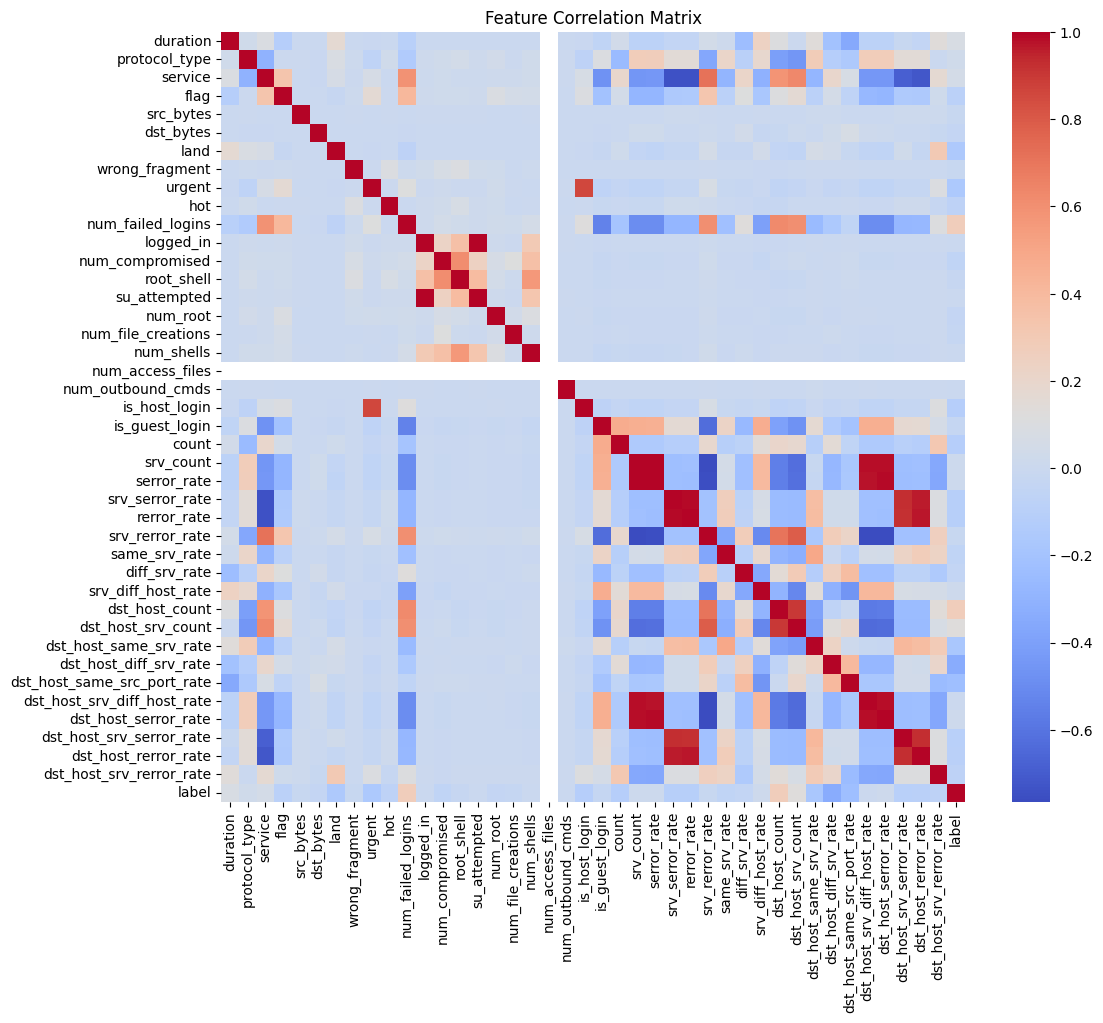

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder

# Convert non-numeric columns to numeric using Label Encoding
non_numeric_cols = df_train.select_dtypes(include=['object']).columns
label_encoders = {}
for col in non_numeric_cols:
	label_encoders[col] = LabelEncoder()
	df_train[col] = label_encoders[col].fit_transform(df_train[col])

# Compute Correlation Matrix
corr_matrix = df_train.corr()

# Plot Heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm")
plt.title("Feature Correlation Matrix")
plt.show()


In [34]:

correct = 0
total = len(y_test_tensor)

with torch.no_grad():
    predictions = model(X_test_tensor)
    predicted_labels = torch.argmax(predictions, axis=1).cpu().numpy()
    actual_labels = y_test_tensor.cpu().numpy()

    correct = sum(predicted_labels == actual_labels)
    accuracy = correct / total * 100

print(f" New Model Accuracy on Full Test Set: {accuracy:.2f}%")


 New Model Accuracy on Full Test Set: 60.30%


In [31]:
import joblib


torch.save(model.state_dict(), "final_dqn_model.pth")
print("Final model saved as final_dqn_model.pth")


joblib.dump(scaler, "scaler.pkl")
print(" Scaler saved as scaler.pkl")



Final model saved as final_dqn_model.pth
 Scaler saved as scaler.pkl


In [33]:



feature_names = X_train.columns.tolist()


joblib.dump(feature_names, "feature_names.pkl")
print(" Feature names saved as feature_names.pkl")


 Feature names saved as feature_names.pkl
